# The Viola-Jones Algorithm

In [2]:
%matplotlib inline

import os
import tarfile
import shutil
import hashlib
import glob
import random
import pickle
from datetime import datetime
from typing import *

from numba import jit
import requests
from joblib import Parallel, delayed

from PIL import Image, ImageOps
import numpy as np
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette('muted')

Our test image will be a colored photo of the fifth Solvay Conference in 1927 ([image source](https://rarehistoricalphotos.com/solvay-conference-probably-intelligent-picture-ever-taken-1927/)), depicting, from front to back and left to right:

- Irving Langmuir, Max Planck, Marie Curie, Hendrik Lorentz, Albert Einstein, Paul Langevin, Charles-Eugène Guye, Charles Thomson Rees Wilson and Owen Richardson in the first row,
- Peter Debye, Martin Knudsen, William Lawrence Bragg, Hendrik Anthony Kramers, Paul Dirac, Arthur Compton, Louis de Broglie, Max Born and Niels Bohr in the second row, as well as
- Auguste Piccard, Émile Henriot, Paul Ehrenfest, Édouard Herzen, Théophile de Donder, Erwin Schrödinger, Jules-Émile Verschaffelt, Wolfgang Pauli, Werner Heisenberg, Ralph Fowler and Léon Brillouin in the back.

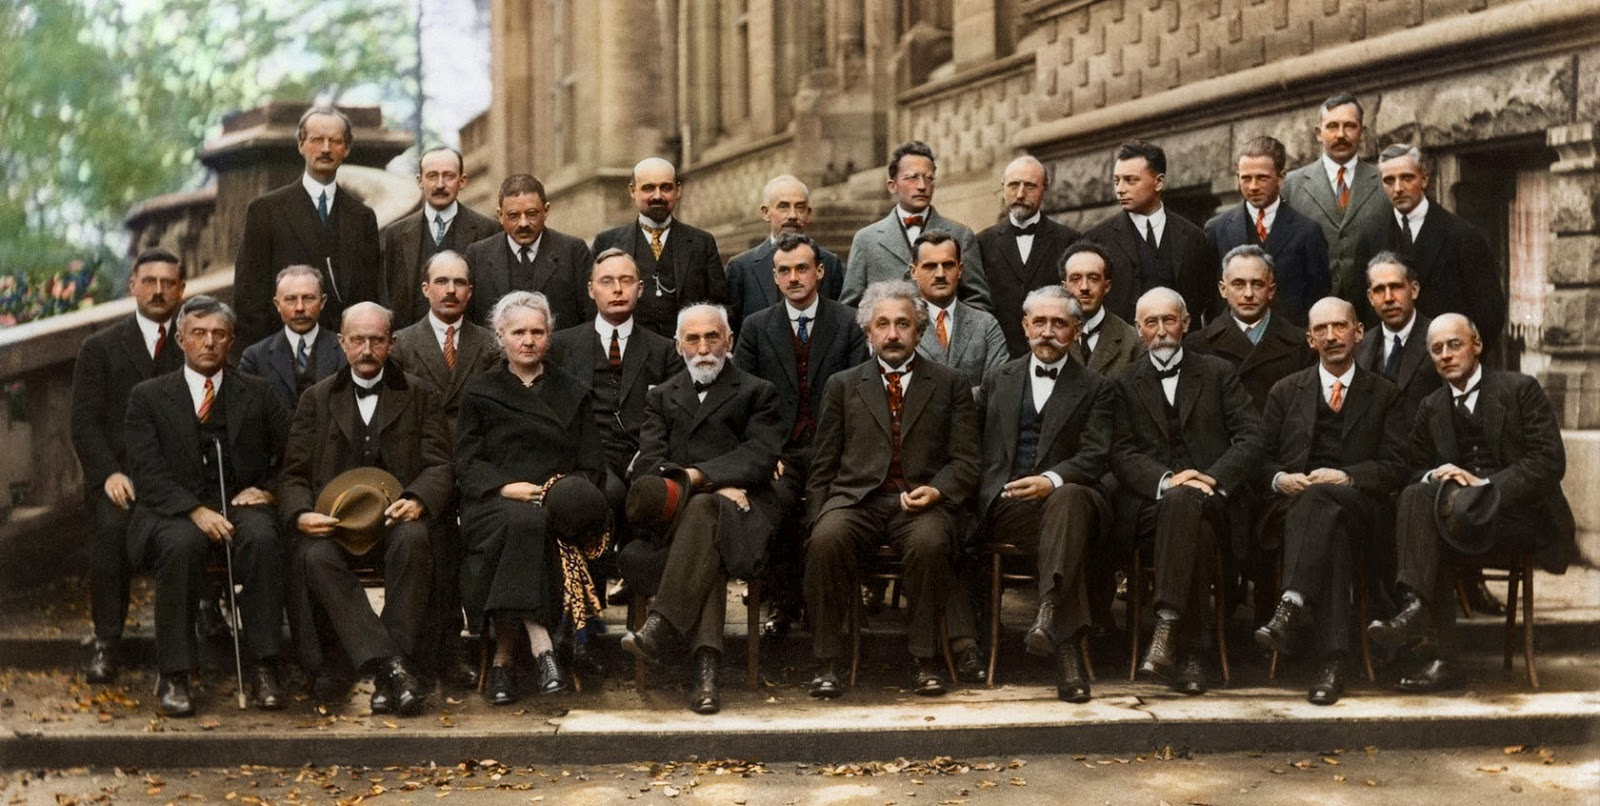

In [52]:
original_image_path = "./images/solvay-conference.jpg"
original_image = Image.open(original_image_path)
original_image

Obviously, any other image would have done just as well.

In the original paper [Rapid object detection using a boosted cascade of simple features](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.10.6807), Viola and Jones work with images of size $382 \times 288$. We will now reduce the image size accordingly.

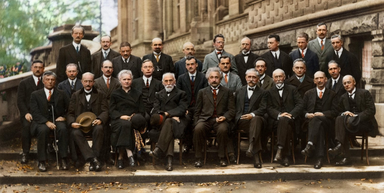

In [53]:
target_size = (384, 288)
thumbnail_image = original_image.copy()
thumbnail_image.thumbnail(target_size, Image.ANTIALIAS)
thumbnail_image

For further processing, we will also convert the image to a NumPy array; in order to display it we will then need to convert it back again.

In [54]:
def to_float_array(img: Image.Image) -> np.ndarray:
    return np.array(img).astype(np.float32) / 255.

def to_image(values: np.ndarray) -> Image.Image:
    return Image.fromarray(np.uint8(values * 255.))

Let's convert the values now.

In [55]:
original = to_float_array(thumbnail_image)

print('Original value range: {0} .. {1}'.format(original.min(), original.max()))

Original value range: 0.0 .. 1.0


## Grayscale conversion

We assume that color information are of no benefit for the task of face detection, which is why we will discard them. Kanan and Cottrell compare different methods of grayscale conversion with respect to recognition tasks in their 2012 paper [Color-to-Grayscale: Does the Method Matter in Image Recognition?](http://tdlc.ucsd.edu/SV2013/Kanan_Cottrell_PLOS_Color_2012.pdf) ([DOI](https://doi.org/10.1371/journal.pone.0029740)). 

They find that for face detection tasks, the _Gleam_ conversion is almost always optimal. In contrast to a simple _Intensity_ conversion

$$
\mathcal{G}_{Intensity} \leftarrow \frac{1}{3}\left(R + G + B\right),
$$

Gleam uses gamma corrected channels

$$
\mathcal{G}_{Gleam} \leftarrow \frac{1}{3}\left(R' + G' + B'\right)
$$

where

$$
t' = \Gamma(t) = t^{1/2.2}.
$$

There the constant $2.2$ is a common choice ([Wikipedia](https://en.wikipedia.org/wiki/Gamma_correction)), yet an somewhat arbitrary one, and finding an optimal value by means of hyperparameter optimization is suggested in the paper. For the moment, it'll do.

In [56]:
def gamma(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

In [57]:
def gleam(values: np.ndarray) -> np.ndarray:
    return np.sum(gamma(values), axis=2) / values.shape[2]

We now convert the image.

In [58]:
grayscale = gleam(original)

print('Grayscale value range: {0} .. {1}'.format(grayscale.min(), grayscale.max()))

Grayscale value range: 0.0 .. 0.986802339553833


Visually inspecting the outcome shows that the image appears to be brighter than before. This is due to the gamma conversion and also specifically mentioned in the paper.

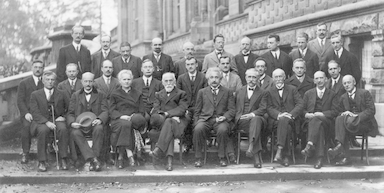

In [59]:
to_image(grayscale)

## Base features

Viola and Jones define four base Haar-like features; two two-rectangle features, one three-rectangle one and a four-rectangle features. They can be understood as follows:

$$
\begin{align}
\mathcal{F}_{2,h} &= \begin{bmatrix}
    1 & -1
    \end{bmatrix} \\
\mathcal{F}_{2,v} &= \begin{bmatrix}
    -1 \\ 1
    \end{bmatrix} \\
\mathcal{F}_{3,h} &= \begin{bmatrix}
    -1 & 1 & -1
    \end{bmatrix} \\
\mathcal{F}_{4} &= \begin{bmatrix}
    1 & -1 \\
    -1 & 1
    \end{bmatrix}
\end{align}.
$$

When overlaying these features on the (original) image, values corresponding to a coefficient of $1$ are added, whereas values corresponding to a $-1$ are subtracted. The papers by Viola and Jones are not clear in this regard, as pointed out by [this StackOverflow question](https://stackoverflow.com/questions/1707620/viola-jones-face-detection-claims-180k-features). We will consider a fifth feature,

$$
\begin{align}
\mathcal{F}_{3,v} &= \begin{bmatrix}
    -1 \\ 1 \\ -1
    \end{bmatrix}
\end{align}.
$$

Rather than applying these features as-is, actual kernels are derived by scaling and positioning these features in a detection window of $24 \times 24$ pixels.

Assuming that the features can only be scaled by powers of two (due to symmetry), a horizontal two-rectangle feature can have the following 12 valid sizes given a $24$ pixel wide window: 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22 and 24. Since the feature is of height 1, there are 24 possible combinations for the height without violating symmetry.

However, given that we also have to position the feature, not all positions are valid:

- A 2 pixel feature can be positioned at $x$ coordinates $0 \dots 22$, resulting in 23 possible combinations.
- A 24 pixel feature can be only positioned at $x$ coordinate $0$, resulting in 1 possible combination.
- A 22 pixel feature can be positioned at $x$ coordinates $0, 1, 2$, resulting in 3 possible combinations.

This yields

$$
n_x\left(width_{feature}\right) = width_{window} - width_{feature} + 1
$$

possible combinations for a specific $width_{feature}$, giving

$$
\begin{align}
    N_{x,2h} &= n_x(2) + n_x(4) + n(6) + \dots + n_x(24) \\
      &= 23 + 21 + 19 \dots + 1 \\
      &= 144
\end{align}
$$

possible combinations for the $x$ position alone. The same reasoning can be applied to the height, which evaluates as

$$
n_y\left(height_{feature}\right) = height_{window} - height_{feature} + 1
$$

and

$$
\begin{align}
    N_{y,2h} &= n_y(1) + n_y(2) + n_y(3) + \dots + n_y(24) \\
      &= 24 + 23 + 22 \dots + 1 \\
      &= 300.
\end{align}
$$

Consequently, the total number of combinations is

$$
\begin{align}
    N_{2h} &= N_{x,2h} \times N_{y,2h} \\
      &= 144 \times 300 \\
      &= 43200.
\end{align}
$$

We can further see that

$$
\begin{align}
    N_{3} &= N_{x,3} \times N_{y,3} \\
      &= 92 \times 300 \\
      &= 27600
\end{align}
$$

and

$$
\begin{align}
    N_{4} &= N_{x,4} \times N_{y,4} \\
      &= 144 \times 144 \\
      &= 20736,
\end{align}
$$

giving a total of

$$
\begin{align}
    N &= 2 \times N_{2} + 2 \times N_{3} + N_{4} \\
      &= 86400 + 55200 + 20736 \\
      &= 162336
\end{align}
$$



In order to save calculation time in this notebook, we're going to use $15\times 15$ windows instead of the originally proposed $25\times 25$ ones.

In [60]:
WINDOW_SIZE = 15

This suits us well, as the faces from the target image are in this size:

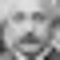

In [61]:
EINSTEIN_POS = (73, 207)
EINSTEIN = grayscale[EINSTEIN_POS[0]:EINSTEIN_POS[0]+WINDOW_SIZE, EINSTEIN_POS[1]:EINSTEIN_POS[1]+WINDOW_SIZE]

to_image(EINSTEIN).resize((4*WINDOW_SIZE, 4*WINDOW_SIZE))

## Integral image

An integral image $\mathcal{I}^\ast$ contains the sum (the _discrete_ integral) of all values top and left of a specific point, i.e. each point $i, j$ is determined by the sum

$$
\mathcal{I}^{\ast}_{i, j} = \sum_{x=0}^{i} \sum_{y=0}^{j} \mathcal{I}_{i, j}
$$

of intensity values of the source image $\mathcal{I}$. 

An interesting property of the integral image is that the sum of pixels within individual areas of it can be expressed by only four value accesses, as is shown in the following figure ([source](http://vinsol.com/blog/2016/06/28/computer-vision-face-detection/)):

![](images/integral-image.png)

Specifically, the sum of the region $x_{left}, y_{top}, x_{right}, y_{bottom}$ can be determined as

$$
s(x_{left}, y_{top}, x_{right}, y_{bottom}) = \mathcal{I}^{\ast}_{x_{right}, y_{bottom}}
                                             - \mathcal{I}^{\ast}_{x_{right}, y_{top}}
                                             - \mathcal{I}^{\ast}_{x_{left}, y_{bottom}}
                                             + \mathcal{I}^{\ast}_{x_{top}, y_{left}}.
$$



In [62]:
def to_integral(img: np.ndarray) -> np.ndarray:
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]

integral = to_integral(grayscale)

Since the values of the integral image are not confined to the interval $0..1$ anymore, we first normalize the integral image for viewing purposes. This is how the result looks like:

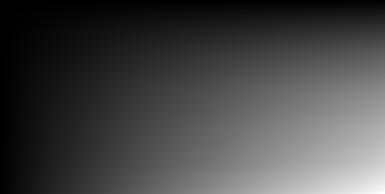

In [63]:
to_image(integral / integral.max())

We can always get back the original image by differentiating:
Basically we are doing (**out[i] = integral[i+1] - integral[i]**)<br>
along axis = 1 then along axis = 0

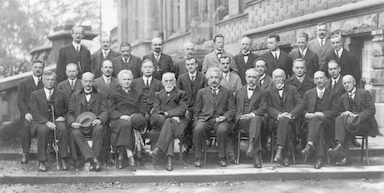

In [64]:
to_image(np.diff(np.diff(integral, axis=1), axis=0))

For easier evaluation, we'll create a helper class `Box` that allows to determine the integral of an image region by means of the integral image.

Using the same example as before:

**NB** : We are adding a padding of 0s for speeding purposes, so that we dont need to test for out of bound indexes if the rectangle we want to calculate happens to cover the entire image

In [65]:
sample_image =  np.array([
    [5, 2, 3, 4, 1], 
    [1, 5, 4, 2, 3],
    [2, 2, 1, 3, 4],
    [3, 5, 6, 4, 5],
    [4, 1, 3, 2, 6]])
sample_integral = to_integral(sample_image)
sample_integral


array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  5,  7, 10, 14, 15],
       [ 0,  6, 13, 20, 26, 30],
       [ 0,  8, 17, 25, 34, 42],
       [ 0, 11, 25, 39, 52, 65],
       [ 0, 15, 30, 47, 62, 81]])

When we pick the region $(1, 1) \dots (4, 3)$, we would sum up

In [66]:
sample_image[1:2+1, 1:3+1]

array([[5, 4, 2],
       [2, 1, 3]])

yielding

In [67]:
np.sum(sample_image[1:2+1, 1:3+1])

17

We can see that we get the same result as before:

In [68]:
x, y          = 1, 1
width, height = 3, 2

coords_x = [x, x + width, x,          x + width]
coords_y = [y, y,         y + height, y + height]
coeffs   = [1, -1,        -1,         1]

np.sum(sample_integral[coords_y, coords_x] * coeffs)

17

In [69]:
class Box:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.coords_x = [x, x + width, x,          x + width]
        self.coords_y = [y, y,         y + height, y + height]
        self.coeffs   = [1, -1,        -1,         1]
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))

Evaluating the box on the same region does indeed yield the expected result:

In [70]:
sample_box = Box(1, 1, 3, 2)
sample_box(sample_integral)

17

Likewise, area of the lower-right value is just the lower-right value:

In [71]:
box = Box(4, 4, 1, 1)
box(sample_integral)

6

In [72]:
box.coords_x, box.coords_y

([4, 5, 4, 5], [4, 4, 5, 5])

# Datasets

In order to train our classifier(s), we need some instances of the class to be found (the faces), and classes to not be found (the background).

In [73]:
dataset_path = 'dataset'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

In order to download the datasets, we're going to use some helper functions:

In [74]:
def download_file(url: str, path: str):
    print('Downloading file ...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    print('Download completed.')
    
def md5(path: str, chunk_size: int=65536) -> str:
    hash_md5 = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def untar(file_path: str, dest_path: str):
    print('Extracting file.')
    with tarfile.open(file_path, 'r:gz') as f:
        f.extractall(dest_path)
    print('Extraction completed.')

# Faces

For positive class ("face"), we're going to use the Yearbook Dataset from [A Century of Portraits:
A Visual Historical Record of American High School Yearbooks](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html).

> Shiry Ginosar, Kate Rakelly, Sarah Sachs, Brian Yin, Crystal Lee, Alexei A. Efros **A Century of Portraits: A Visual Historical Record of American High School Yearbooks**, in IEEE Transactions on Computational Imaging, Vol. 3, No. 3, September 2017. [PDF](https://people.eecs.berkeley.edu/~shiry/publications/IEEE_yearbooks.pdf), [BibTeX](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html#yearbooks_IEEE)

It contains 37,921 pictures of frontal-facing portraits of size $186 \times 171$ where we will assume the face to be in the center.

In [75]:
faces_url = 'https://www.dropbox.com/s/ubjjoo0b2wz4vgz/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz?dl=1'
faces_md5 = 'ab853c17ca6630c191457ff1fb16c1a4'

faces_archive = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz')
faces_dir = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned')

if not os.path.exists(faces_archive) or md5(faces_archive) != faces_md5:
    download_file(faces_url, faces_archive)

Download completed.


In [76]:
if not os.path.exists(faces_dir):
    untar(faces_archive, dataset_path)

Extracting file.
Extraction completed.


In [77]:
face_image_files = glob.glob(os.path.join(faces_dir, '**', '*.png'), recursive=True)
len(face_image_files)

37921

When opening the face images, we're going to crop a bit from the top, in order to remove part of the hair. This aligns it more with the faces in our Solvay image.

In [78]:
def open_face(path: str, resize: bool=True) -> Image.Image:
    CROP_TOP = 50
    
    img = Image.open(path)
    img = to_image(gamma(to_float_array(img)[CROP_TOP:, :]))
    min_size = np.min(img.size)
    img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
    return img.convert('L')

Let's create some helper function to stitch together images:

In [79]:
def merge_images(files: Iterable[str], open_fun: Callable, resize: bool=False) -> Image.Image:
    images = [open_fun(f, resize) for f in files]
    sizes = [img.size for img in images]
    collage_width = np.sum([size[0] for size in sizes])
    collage_height = np.max([size[1] for size in sizes])

    result = Image.new('L', (collage_width, collage_height))
    x_offset = 0
    for img, size in zip(images, sizes):
        result.paste(im=img, box=(x_offset, 0))
        x_offset += size[0]
    return result

We can now have a look at a sample of the dataset. Note that the images appear brighter than they would in the original dataset because we're applying gamma correction.

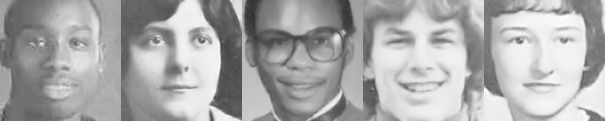

In [80]:
random.seed(1000)
random_face_files = random.sample(face_image_files, 5)
merge_images(random_face_files, open_face)

For comparison, when resized to $15 \times 15$ pixels, this is how it looks like:

In [81]:
merge_images(random_face_files, open_face, True)

## Backgrounds

For the negative class ("not a face") we will make use of the [Stanford Backgrounds Dataset](http://dags.stanford.edu/projects/scenedataset.html) for scene understanding. It contains 715 images of various scenes, from which we will randomly crop regions to be used as background classes.

> S. Gould, R. Fulton, D. Koller. **Decomposing a Scene into Geometric and Semantically Consistent Regions.** Proceedings of International Conference on Computer Vision (ICCV), 2009. [pdf](http://www.stanford.edu/~sgould/papers/iccv09-sceneDecomposition.pdf)

The images are approximately of size $320 \times 240$ and do contain faces in camera-facing poses, but we'll ignore this for the time being. After all, the chance of randomly selecting a valid face that is exactly within the window region is pretty slim.

In [82]:
backgrounds_url = 'http://dags.stanford.edu/data/iccv09Data.tar.gz'
backgrounds_md5 = 'f469cf0ab459d94990edcf756694f4d5'

backgrounds_archive = os.path.join(dataset_path, 'iccv09Data.tar.gz')
backgrounds_dir = os.path.join(dataset_path, 'iccv09Data')

if not os.path.exists(backgrounds_archive) or md5(backgrounds_archive) != faces_md5:
    download_file(backgrounds_url, backgrounds_archive)

KeyboardInterrupt: 

In [ ]:
if not os.path.exists(backgrounds_dir):
    untar(backgrounds_archive, dataset_path)

In [ ]:
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
len(background_image_files)

715

In [ ]:
def random_crop(img: Image.Image) -> Image.Image:
    max_allowed_size = np.min(img.size)
    size = random.randint(WINDOW_SIZE, max_allowed_size)
    max_width = img.size[0] - size - 1
    max_height = img.size[1] - size - 1
    left = 0 if (max_width <= 1)  else random.randint(0, max_width)
    top  = 0 if (max_height <= 1) else random.randint(0, max_height)
    return img.crop((left,top,left+size,top+size))

def open_background(path: str, resize: bool=True) -> Image.Image:
    img = Image.open(path)
    img = to_image(gleam(to_float_array(img)))
    img = random_crop(img)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
    return img.convert('L')

Due to the random cropping, the results look a bit mixed:

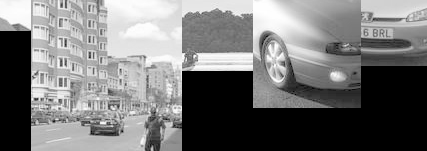

In [ ]:
random.seed(1000)
random_background_files = random.sample(background_image_files, 5)
merge_images(random_background_files, open_background)

When resizing, some operation seems to mess with the random state; this doesn't affect the overall functionality of the operation though.

In [ ]:
random.seed(1000)
merge_images(random_background_files, open_background, True)

# Training the classifier

Before we can start the training process, we need to define the features in a way they can actually be evaluated. For this we're going to construct a class for each feature type and then parameterize it according to all possible values, yielding about 160k instances. The best features will be picked later by exhaustive search.

In [ ]:
class Feature:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    
    def __call__(self, integral_image: np.ndarray) -> float:
        try:
            return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))
        except IndexError as e:
            raise IndexError(str(e) + ' in ' + str(self))
    
    def __repr__(self):
        return f'{self.__class__.__name__}(x={self.x}, y={self.y}, width={self.width}, height={self.height})'

With this base class we can define our features:

In [ ]:
class Feature2h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        self.coords_x = [x, x + hw, x, x + hw, x + hw, x + width, x + hw, x + width]
        self.coords_y = [y,      y,          y + height, y + height,
                         y,      y,          y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,
                         -1,     1,          1,         -1]

Using the same example as above,

In [ ]:
sample_image

array([[5, 2, 3, 4, 1],
       [1, 5, 4, 2, 3],
       [2, 2, 1, 3, 4],
       [3, 5, 6, 4, 5],
       [4, 1, 3, 2, 6]])

In [ ]:
sample_integral

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  5,  7, 10, 14, 15],
       [ 0,  6, 13, 20, 26, 30],
       [ 0,  8, 17, 25, 34, 42],
       [ 0, 11, 25, 39, 52, 65],
       [ 0, 15, 30, 47, 62, 81]])

we find that an $\mathcal{F}_{2,h}$ of width 2 and height 4 in the bottom right region

In [ ]:
sample_image[1:1+4, 3:3+2]

array([[2, 3],
       [3, 4],
       [4, 5],
       [2, 6]])

would add

In [ ]:
sample_image[1:1+4, 3:3+1]

array([[2],
       [3],
       [4],
       [2]])

and subtract

In [ ]:
sample_image[1:1+4, 4:4+1]

array([[3],
       [4],
       [5],
       [6]])

yielding

In [ ]:
np.sum(sample_image[1:1+4, 3:3+1]) - np.sum(sample_image[1:1+4, 4:4+1])

-7

Which is what we get with

In [ ]:
Box(x=3, y=1, width=1, height=4)(sample_integral) - Box(x=4, y=1, width=1, height=4)(sample_integral)

-7

which is precisely the output of our implementation:

In [ ]:
Feature2h(x=3, y=1, width=2, height=4)(sample_integral)

-7

We'll now create the remaining features.

In [ ]:
class Feature2v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hh = height // 2        
        self.coords_x = [x,      x + width,  x,          x + width,
                         x,      x + width,  x,          x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [-1,     1,          1,         -1,
                         1,     -1,         -1,          1]
    
expected = - Box(0, 1, 4, 2)(sample_integral) + Box(0, 3, 4, 2)(sample_integral)
actual = Feature2v(0, 1, 4, 4)(sample_integral)
assert expected == actual, f'{expected} == {actual}'

In [ ]:
class Feature3h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        tw = width // 3
        self.coords_x = [x,        x + tw,    x,          x + tw,
                         x + tw,   x + 2*tw,  x + tw,     x + 2*tw,
                         x + 2*tw, x + width, x + 2*tw,   x + width]
        self.coords_y = [y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height]
        self.coeffs   = [-1,       1,         1,         -1,
                          1,      -1,        -1,          1,
                         -1,       1,         1,         -1]

expected = - Box(0, 0, 1, 2)(sample_integral) + Box(1, 0, 1, 2)(sample_integral) - Box(2, 0, 1, 2)(sample_integral)
actual = Feature3h(0, 0, 3, 2)(sample_integral)
assert expected == actual, f'{expected} == {actual}'

In [ ]:
class Feature3v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        th = height // 3
        self.coords_x = [x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width]
        self.coords_y = [y,        y,          y + th,     y + th,
                         y + th,   y + th,     y + 2*th,   y + 2*th,
                         y + 2*th, y + 2*th,   y + height, y + height]
        self.coeffs   = [-1,        1,         1,         -1,
                          1,       -1,        -1,          1,
                         -1,        1,         1,         -1]

expected = - Box(0, 0, 2, 1)(sample_integral) + Box(0, 1, 2, 1)(sample_integral) - Box(0, 2, 2, 1)(sample_integral)
actual = Feature3v(0, 0, 2, 3)(sample_integral)
assert expected == actual, f'{expected} == {actual}'

In [ ]:
class Feature4(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        hh = height // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,     # upper row
                         x + hw, x + width,  x + hw,     x + width,
                         x,      x + hw,     x,          x + hw,     # lower row
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,     # upper row
                         y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height, # lower row
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,          # upper row
                         -1,     1,          1,         -1,
                         -1,     1,          1,         -1,          # lower row
                          1,    -1,         -1,          1]

expected = Box(0, 0, 2, 2)(sample_integral) - Box(2, 0, 2, 2)(sample_integral) \
         - Box(0, 2, 2, 2)(sample_integral) + Box(2, 2, 2, 2)(sample_integral)
actual = Feature4(0, 0, 4, 4)(sample_integral)
assert expected == actual, f'{expected} == {actual}'

We will now instantiate the feature detectors.

In [ ]:
Size = NamedTuple('Size', [('height', int), ('width', int)])
Location = NamedTuple('Location', [('top', int), ('left', int)])

def possible_position(size: int, window_size: int = WINDOW_SIZE) -> Iterable[int]:
    return range(0, window_size - size + 1)

def possible_locations(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Location]:
    return (Location(left=x, top=y)
            for x in possible_position(base_shape.width, window_size) 
            for y in possible_position(base_shape.height, window_size))

def possible_shapes(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Size]:
    base_height = base_shape.height
    base_width = base_shape.width
    return (Size(height=height, width=width)
            for width in range(base_width, window_size + 1, base_width)
            for height in range(base_height, window_size + 1, base_height))

In a $5\times 5$ window, which $4\times 4$ boxes can we fit?

$$
\begin{bmatrix}
0,0 & 0,1 & 0,2 & 0,3 & 0,4 \\
1,0 & 1,1 & 1,2 & 1,3 & 1,4 \\
2,0 & 2,1 & 2,2 & 2,3 & 2,4 \\
3,0 & 3,1 & 3,2 & 3,3 & 3,4 \\
4,0 & 4,1 & 4,2 & 4,3 & 4,4
\end{bmatrix}
$$

In [ ]:
list(possible_locations(Size(4, 4), 5)), list(possible_shapes(Size(4, 4), 5))

([Location(top=0, left=0),
  Location(top=1, left=0),
  Location(top=0, left=1),
  Location(top=1, left=1)],
 [Size(height=4, width=4)])

For shapes of dimensions $(1, 2)$ (one high, two wide), the list is longer:

In [ ]:
list(possible_locations(Size(height=1, width=2), 5))

[Location(top=0, left=0),
 Location(top=1, left=0),
 Location(top=2, left=0),
 Location(top=3, left=0),
 Location(top=4, left=0),
 Location(top=0, left=1),
 Location(top=1, left=1),
 Location(top=2, left=1),
 Location(top=3, left=1),
 Location(top=4, left=1),
 Location(top=0, left=2),
 Location(top=1, left=2),
 Location(top=2, left=2),
 Location(top=3, left=2),
 Location(top=4, left=2),
 Location(top=0, left=3),
 Location(top=1, left=3),
 Location(top=2, left=3),
 Location(top=3, left=3),
 Location(top=4, left=3)]

We can also have different variations of that shape:

In [ ]:
list(possible_shapes(Size(height=1, width=2), 5))

[Size(height=1, width=2),
 Size(height=2, width=2),
 Size(height=3, width=2),
 Size(height=4, width=2),
 Size(height=5, width=2),
 Size(height=1, width=4),
 Size(height=2, width=4),
 Size(height=3, width=4),
 Size(height=4, width=4),
 Size(height=5, width=4)]

We can instantiate all possible shapes of the feature:

In [ ]:
feature2h = list(Feature2h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature2v = list(Feature2v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3h = list(Feature3h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3v = list(Feature3v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=3, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature4  = list(Feature4(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

features = feature2h + feature2v + feature3h + feature3v + feature4

print(f'Number of feature2h features: {len(feature2h)}')
print(f'Number of feature2v features: {len(feature2v)}')
print(f'Number of feature3h features: {len(feature3h)}')
print(f'Number of feature3v features: {len(feature3v)}')
print(f'Number of feature4 features:  {len(feature4)}')
print(f'Total number of features:     {len(features)}')

Number of feature2h features: 6720
Number of feature2v features: 6720
Number of feature3h features: 4200
Number of feature3v features: 4200
Number of feature4 features:  3136
Total number of features:     24976


## Sampling data

For training, we want to online sample training data. We start by defining a function to sample examples:

In [ ]:
def sample_data(p: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    xs = []
    xs.extend([to_float_array(open_face(f)) for f in random.sample(face_image_files, p)])
    xs.extend([to_float_array(open_background(f)) for f in np.random.choice(background_image_files, n, replace=True)])

    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In order to compensate for lighting differences, we variance normalize the training data. For this we obtain a sample mean and standard deviation from the training set:

In [ ]:
image_samples, _ = sample_data(100, 100)

sample_mean = image_samples.mean()
sample_std = image_samples.std()
del image_samples

print(f'Sample mean: {sample_mean}, standard deviation: {sample_std}')

Sample mean: 0.7006033658981323, standard deviation: 0.18898972868919373


In [ ]:
def normalize(im: np.ndarray, mean: float = sample_mean, std: float = sample_std) -> np.ndarray:
    return (im - mean) / std

def sample_data_normalized(p: int, n: int, mean: float = sample_mean, std: float = sample_std) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = sample_data(p, n)
    xs = normalize(xs, mean, std)
    return xs, ys

Using normalization, we expect to see approximately zero mean and unit variance:

In [ ]:
xs, _ = sample_data_normalized(100, 100)

print(f'Example mean: {xs.mean()}, standard deviation: {xs.std()}')
del xs
del _

Example mean: -0.029382454231381416, standard deviation: 0.9685494899749756


## Evaluating the features for classification

Each of our features generates a scalar value for a given input image. We will obtain a classifier from this feature by finding a threshold, using which we will decide whether an image is containing a face or whether it doesn't. We select the threshold in a way such that it minimizes false-positive and false-negative classification errors.

Let's look at Einstein's face again.

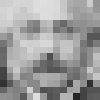

In [ ]:
to_image(EINSTEIN).resize((100, 100))

Let's start by "arbitrarily" selecting a vertical 2-rectangle feature that subtracts intensities in the region $(2, 4) \dots (12, 6)$ and adds intensities in the region $(2, 6) \dots (12, 8)$; this should roughly cover the region of the eyes in the dataset.

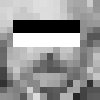

In [ ]:
left, width = 2, 10
top, height = 3, 4

EINSTEIN_MASKED = EINSTEIN.copy()
EINSTEIN_MASKED[top:top+height//2, left:left+width] = 0
EINSTEIN_MASKED[top+height//2:top+height, left:left+width] = 1
to_image(EINSTEIN_MASKED).resize((100, 100))

In [ ]:
f = Feature2v(x=left, y=top, width=width, height=height)

random.seed(0)
np.random.seed(0)
xs, ys = sample_data_normalized(50, 50)
xs = np.array([to_integral(x) for x in xs])
zs = np.array([f(x) for x in xs])

We can measure our classification performance by means of precision and recall.

- Recall is the percentage of faces in the dataset that were correctly identified as such; it penalizes false negatives.
- Precision is the percentage of correctly identified positives; it penalizes false positives.

Since both precision and recall change with the threshold we select, we can obtain a Precision-Recall curve that tells us how precision and recall change, given a specific threshold.

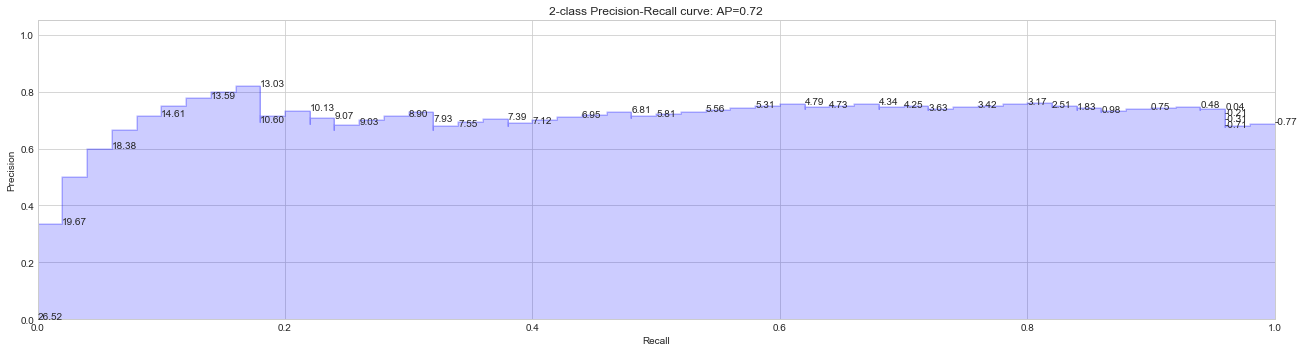

In [ ]:
average_precision = average_precision_score(ys, zs)
precision, recall, thresholds = precision_recall_curve(ys, zs)

plt.figure(figsize=(18, 5))
plt.step(recall, precision, color='b', alpha=0.2, where='post');
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

for i, (p, r, t) in enumerate(zip(precision, recall, thresholds)):
    if i % 2 == 0:
        plt.annotate(f'{t:.2f}', xy=(r, p))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.tight_layout()

It appears as if $0.04$ is a threshold that simultaneously maximizes precision and recall. Let's have a look at the precision and recall values, as well as the confusion matrix for this threshold.

In [ ]:
PredictionStats = NamedTuple('PredictionStats', [('tn', int), ('fp', int), ('fn', int), ('tp', int)])

def prediction_stats(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[np.ndarray, PredictionStats]:
    c = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c.ravel()
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

We find that our precision is indeed at 74% with a recall of 96%, i.e. 96% of all faces were correctly identified and we were 74% correct when we decided an image contains a face.

In [ ]:
theta = 0.04
c, s = prediction_stats(ys, zs >= theta)

print(f'Precision {s.tp/(s.tp+s.fp):.3}, recall {s.tp/(s.tp+s.fn):.3}.')

Precision 0.738, recall 0.96.


This looks like it is indeed an OK threshold value for the picked sample; however, we need to find the actual minimizer algorithmically.

It is the job of AdaBoost to take this information to its (and our) advantage.

# Adaptive Boosting

In [ ]:
random.seed(18151210)
np.random.seed(18151210)
xs, ys = sample_data_normalized(1000, 700)

Again, we're going to need the integral images:

In [ ]:
xis = np.array([to_integral(x) for x in xs])
xs.shape, xis.shape

((1700, 15, 15), (1700, 16, 16))

In order to get a feeling for our dataset sample, here's what the average face looks like:

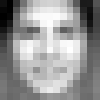

In [ ]:
average_face = np.sum(xs[ys > .5], axis=0) / xs[ys > .5].shape[0]
average_face = (average_face - average_face.min()) / (average_face.max() - average_face.min())
to_image(average_face).resize((100, 100))

To make it easier on the eyes, here's the same image antialiased.

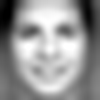

In [ ]:
to_image(average_face).resize((100, 100), Image.ANTIALIAS)

For comparison, here's Einstein:

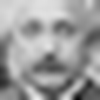

In [ ]:
to_image(EINSTEIN).resize((100, 100), Image.ANTIALIAS)

We can do the same for the background. Here's how it looks like:

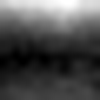

In [ ]:
average_background = np.sum(xs[ys < .5], axis=0) / xs[ys < .5].shape[0]
average_background = (average_background - average_background.min()) / (average_background.max() - average_background.min())
to_image(average_background).resize((100, 100), Image.ANTIALIAS)

Let's also define some helper types.

In [ ]:
ThresholdPolarity = NamedTuple('ThresholdPolarity', [('threshold', float), ('polarity', float)])

ClassifierResult = NamedTuple('ClassifierResult', [('threshold', float), ('polarity', int), 
                                                   ('classification_error', float),
                                                   ('classifier', Callable[[np.ndarray], float])])

WeakClassifier = NamedTuple('WeakClassifier', [('threshold', float), ('polarity', int), 
                                               ('alpha', float), 
                                               ('classifier', Callable[[np.ndarray], float])])

One of the attributes of AdaBoost is that it combines multiple weak learners $h_t(x)$ into a strong learner $C(x)$.
Here, the weak learner $h(x)$ is defined given input window $x$ (of size $24\times 24$ in the original paper), polarity $p$, feature $f$ (with value $f(x)$) and threshold $\theta$ as

$$
h(x, f, p, \theta) = \begin{cases} 
    1 & \text{if } pf(x) < p\theta \\  
    0 & \text{otherwise}
\end{cases}
$$

In [ ]:
@jit
def weak_classifier(x: np.ndarray, f: Feature, polarity: float, theta: float) -> float:
    return 1. if (polarity * f(x)) < (polarity * theta) else 0.

@jit
def run_weak_classifier(x: np.ndarray, c: WeakClassifier) -> float:
    return weak_classifier(x=x, f=c.classifier, polarity=c.polarity, theta=c.threshold)

whereas the strong learner $C(X)$ is defined as

$$
C(x) = \begin{cases} 
    1 & \text{if } \sum_{t=1}^{T} \alpha_t h_t(x) \geq \frac{1}{2} \sum_{t=1}^{T} \alpha_t \\  
    0 & \text{otherwise.}
\end{cases}
$$

Here's the implementation:

In [ ]:
@jit
def strong_classifier(x: np.ndarray, weak_classifiers: List[WeakClassifier]) -> int:
    sum_hypotheses = 0.
    sum_alphas = 0.
    for c in weak_classifiers:
        sum_hypotheses += c.alpha * run_weak_classifier(x, c)
        sum_alphas += c.alpha
    return 1 if (sum_hypotheses >= .5*sum_alphas) else 0

We regularly need to renomarlize the input weights to obtain a probability distribution:

In [ ]:
def normalize_weights(w: np.ndarray) -> np.ndarray:
    return w / w.sum()

As before, we need to automatically determine the best threshold and polarity. There are some discussions here:

- [Viola Jones threshold value Haar features error value
](https://stackoverflow.com/questions/39109848/viola-jones-threshold-value-haar-features-error-value)

Given the running sums $S^+$ and $S^-$, as well as the total sums $T^+$ and $T^-$, the goal is to minimize the error $e$ such that

$$
\epsilon = \min\left( S^+ + \left(T^- - S^-\right) \quad,\quad S^- + \left(T^+ - S^+\right) \right).
$$

The first term, $S^+ + \left(T^- - S^-\right)$, is associated with the error of labelling all items below this threshold as "negative" (implying a detector polarity of $-1$), while labelling all above as "positive" and vice versa (i.e. a polarity of $+1$).

While doing so, we keep track of the individual values for displaying purposes:

In [ ]:
@jit
def build_running_sums(ys: np.ndarray, ws: np.ndarray) -> Tuple[float, float, List[float], List[float]]:
    s_minus, s_plus = 0., 0.
    t_minus, t_plus = 0., 0.
    s_minuses, s_pluses = [], []
    
    for y, w in zip(ys, ws):
        if y < .5:
            s_minus += w
            t_minus += w
        else:
            s_plus += w
            t_plus += w
        s_minuses.append(s_minus)
        s_pluses.append(s_plus)
    return t_minus, t_plus, s_minuses, s_pluses


@jit
def find_best_threshold(zs: np.ndarray, t_minus: float, t_plus: float, s_minuses: List[float], s_pluses: List[float]) -> ThresholdPolarity:
    min_e = float('inf')
    min_z, polarity = 0, 0
    for z, s_m, s_p in zip(zs, s_minuses, s_pluses):
        error_1 = s_p + (t_minus - s_m)
        error_2 = s_m + (t_plus - s_p)
        if error_1 < min_e:
            min_e = error_1
            min_z = z
            polarity = -1
        elif error_2 < min_e:
            min_e = error_2
            min_z = z
            polarity = 1
    return ThresholdPolarity(threshold=min_z, polarity=polarity)


def determine_threshold_polarity(ys: np.ndarray, ws: np.ndarray, zs: np.ndarray) -> ThresholdPolarity:  
    # Sort according to score
    p = np.argsort(zs)
    zs, ys, ws = zs[p], ys[p], ws[p]
    
    # Build running sums
    t_minus, t_plus, s_minuses, s_pluses = build_running_sums(ys, ws)
    
    # Determine the best threshold: select optimal threshold.
    return find_best_threshold(zs, t_minus, t_plus, s_minuses, s_pluses) 

With this, we can determine the weighted error alongside the best threshold and polarity for a feature:

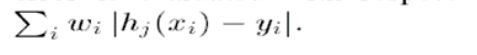

In [5]:
original_image_path = "./images/Screenshot from 2022-06-01 18-48-32.png"
asd = Image.open(original_image_path)
asd


In [ ]:
def apply_feature(f: Feature, xis: np.ndarray, ys: np.ndarray, ws: np.ndarray, parallel: Optional[Parallel] = None) -> ClassifierResult:   
    if parallel is None:
        parallel = Parallel(n_jobs=-1, backend='threading')
    
    # Determine all feature values
    zs = np.array(parallel(delayed(f)(x) for x in xis))
    
    # Determine the best threshold
    result = determine_threshold_polarity(ys, ws, zs)
            
    # Determine the classification error
    classification_error = 0.
    for x, y, w in zip(xis, ys, ws):
        h = weak_classifier(x, f, result.polarity, result.threshold)
        classification_error += w * np.abs(h - y)
            
    return ClassifierResult(threshold=result.threshold, polarity=result.polarity, 
                            classification_error=classification_error, classifier=f)

In [ ]:
STATUS_EVERY     = 2000
KEEP_PROBABILITY = 1./4.

def build_weak_classifiers(prefix: str, num_features: int, xis: np.ndarray, ys: np.ndarray, features: List[Feature], ws: Optional[np.ndarray] = None) -> Tuple[List[WeakClassifier], List[float]]:
    if ws is None:
        m = len(ys[ys < .5])  # number of negative example
        l = len(ys[ys > .5])  # number of positive examples

        # Initialize the weights
        ws = np.zeros_like(ys)
        ws[ys < .5] = 1./(2.*m)
        ws[ys > .5] = 1./(2.*l)
    
    # Keep track of the history of the example weights.
    w_history = [ws]

    total_start_time = datetime.now()
    with Parallel(n_jobs=-1, backend='threading') as parallel:
        weak_classifiers = []  # type: List[WeakClassifier]
        for t in range(num_features):
            print(f'Building weak classifier {t+1}/{num_features} ...')
            start_time = datetime.now()
            
            # Normalize the weights
            ws = normalize_weights(ws)
            
            status_counter = STATUS_EVERY

            # Select best weak classifier for this round
            best = ClassifierResult(polarity=0, threshold=0, classification_error=float('inf'), classifier=None)
            for i, f in enumerate(features):
                status_counter -= 1
                improved = False

                # Python runs singlethreaded. To speed things up,
                # we're only anticipating every other feature, give or take.
                if KEEP_PROBABILITY < 1.:
                    skip_probability = np.random.random()
                    if skip_probability > KEEP_PROBABILITY:
                        continue

                result = apply_feature(f, xis, ys, ws, parallel)
                if result.classification_error < best.classification_error:
                    improved = True
                    best = result

                # Print status every couple of iterations.
                if improved or status_counter == 0:
                    current_time = datetime.now()
                    duration = current_time - start_time
                    total_duration = current_time - total_start_time
                    status_counter = STATUS_EVERY
                    if improved:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(features)} {100*i/len(features):.2f}% evaluated. Classification error improved to {best.classification_error:.5f} using {str(best.classifier)} ...')
                    else:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(features)} {100*i/len(features):.2f}% evaluated.')

            # After the best classifier was found, determine alpha
            beta = best.classification_error / (1 - best.classification_error)
            alpha = np.log(1. / beta)
            
            # Build the weak classifier
            classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.classifier, alpha=alpha)
            
            # Update the weights for misclassified examples
            for i, (x, y) in enumerate(zip(xis, ys)):
                h = run_weak_classifier(x, classifier)
                e = np.abs(h - y)
                ws[i] = ws[i] * np.power(beta, 1-e)
                ## e == 0 if there is no error 
            # Register this weak classifier           
            weak_classifiers.append(classifier)
            w_history.append(ws)
        
            pickle.dump(classifier, open(f'{prefix}-weak-learner-{t+1}-of-{num_features}.pickle', 'wb'))
    
    print(f'Done building {num_features} weak classifiers.')
    return weak_classifiers, w_history

In [ ]:
random.seed(1337)
np.random.seed(1337)
test_xs, test_ys = sample_data_normalized(1000, 1000)
test_xis = np.array([to_integral(x) for x in test_xs])

In [ ]:
assert xis.shape[1:3] == (WINDOW_SIZE+1, WINDOW_SIZE+1), xis.shape
weak_classifiers, w_history = build_weak_classifiers('1st', 2, xis, ys, features)

Building weak classifier 1/2 ...
t=1/2 0.54s (0.53s in this stage) 1/24976 0.00% evaluated. Classification error improved to 0.38650 using Feature2h(x=0, y=0, width=2, height=1) ...
t=1/2 0.68s (0.68s in this stage) 5/24976 0.02% evaluated. Classification error improved to 0.33729 using Feature2h(x=0, y=4, width=2, height=1) ...
t=1/2 0.83s (0.82s in this stage) 6/24976 0.02% evaluated. Classification error improved to 0.33493 using Feature2h(x=0, y=5, width=2, height=1) ...
t=1/2 1.74s (1.73s in this stage) 21/24976 0.08% evaluated. Classification error improved to 0.24279 using Feature2h(x=1, y=5, width=2, height=1) ...
t=1/2 1.88s (1.88s in this stage) 22/24976 0.08% evaluated. Classification error improved to 0.20250 using Feature2h(x=1, y=6, width=2, height=1) ...
t=1/2 5.22s (5.22s in this stage) 125/24976 0.50% evaluated. Classification error improved to 0.18450 using Feature2h(x=8, y=4, width=2, height=1) ...
t=1/2 7.06s (7.05s in this stage) 168/24976 0.67% evaluated. Classifi

In [ ]:
weak_classifiers

[WeakClassifier(threshold=4.731034517288208, polarity=-1, alpha=2.4520918016268536, classifier=Feature2v(x=2, y=4, width=10, height=4)),
 WeakClassifier(threshold=-3.2577762603759766, polarity=1, alpha=1.9849678025392439, classifier=Feature2h(x=1, y=0, width=2, height=10))]

### Evaluation of the classifier(s)

For evaluation, let's pick some test images:

In [ ]:
random.seed(1337)
np.random.seed(1337)
test_xs, test_ys = sample_data_normalized(1000, 700)
test_xis = np.array([to_integral(x) for x in test_xs])

Here's the performance of the first weak classifier:

Precision 0.89, recall 0.98, false positive rate 0.17, false negative rate 0.01.


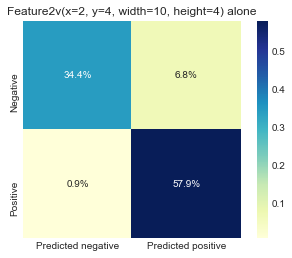

In [ ]:
ys_1 = np.array([run_weak_classifier(x, weak_classifiers[0]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'{weak_classifiers[0].classifier} alone');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

This is the performance of the second weak classifier, conditioned on the first one:

Precision 0.93, recall 0.77, false positive rate 0.08, false negative rate 0.23.


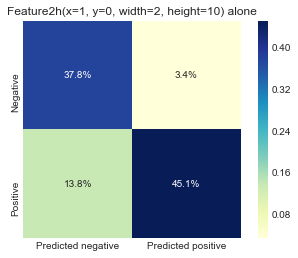

In [ ]:
ys_2 = np.array([run_weak_classifier(x, weak_classifiers[1]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_2)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'{weak_classifiers[1].classifier} alone');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

This is the output of the combined classifier:

Precision 0.89, recall 0.98, false positive rate 0.17, false negative rate 0.01.


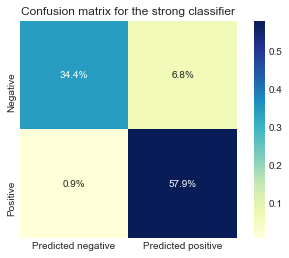

In [ ]:
ys_strong = np.array([strong_classifier(x, weak_classifiers) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for the strong classifier');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Let's test it on Einstein:

In [ ]:
strong_classifier(to_integral(normalize(EINSTEIN)), weak_classifiers)

1

## Building a stronger learner

In their paper, Viola and Jones describe a cascaded decision tree, where the first cascade containing two features rejects some of the background, but detects all of the faces. Only for these positives, the second stage is executed, consisting of ten features. If this evaluates to true, a third stage is used, consisting of 25 features, followed by three more stages of 50 classifiers each.

Let's train ten more classifiers:

In [ ]:
random.seed(1338)
np.random.seed(1338)
test_xs, test_ys = sample_data_normalized(1000, 1000)
test_xis = np.array([to_integral(x) for x in test_xs])

In [ ]:
weak_classifiers_2, w_history_2 = build_weak_classifiers('2nd', 10, xis, ys, features)  # , w_history[-1])

Building weak classifier 1/10 ...
t=1/10 0.17s (0.16s in this stage) 1/24976 0.00% evaluated. Classification error improved to 0.38650 using Feature2h(x=0, y=0, width=2, height=1) ...
t=1/10 0.31s (0.31s in this stage) 4/24976 0.01% evaluated. Classification error improved to 0.34643 using Feature2h(x=0, y=3, width=2, height=1) ...
t=1/10 0.46s (0.46s in this stage) 5/24976 0.02% evaluated. Classification error improved to 0.33729 using Feature2h(x=0, y=4, width=2, height=1) ...
t=1/10 0.61s (0.61s in this stage) 6/24976 0.02% evaluated. Classification error improved to 0.33493 using Feature2h(x=0, y=5, width=2, height=1) ...
t=1/10 1.49s (1.49s in this stage) 22/24976 0.08% evaluated. Classification error improved to 0.20250 using Feature2h(x=1, y=6, width=2, height=1) ...
t=1/10 5.24s (5.24s in this stage) 167/24976 0.66% evaluated. Classification error improved to 0.20086 using Feature2h(x=11, y=1, width=2, height=1) ...
t=1/10 11.15s (11.15s in this stage) 285/24976 1.14% evaluated

In [ ]:
weak_classifiers_2

[WeakClassifier(threshold=2.697524070739746, polarity=-1, alpha=2.500014794802047, classifier=Feature2v(x=3, y=4, width=3, height=4)),
 WeakClassifier(threshold=2.718273639678955, polarity=-1, alpha=1.9072547573445398, classifier=Feature2h(x=8, y=1, width=6, height=2)),
 WeakClassifier(threshold=-2.263363838195801, polarity=1, alpha=1.8097288816053978, classifier=Feature3h(x=7, y=3, width=3, height=6)),
 WeakClassifier(threshold=-0.7470054626464844, polarity=1, alpha=1.8800325402234253, classifier=Feature2v(x=5, y=13, width=3, height=2)),
 WeakClassifier(threshold=1.680765151977539, polarity=-1, alpha=2.1087113494119274, classifier=Feature4(x=7, y=3, width=4, height=6)),
 WeakClassifier(threshold=-0.5187544822692871, polarity=-1, alpha=1.5742000715624718, classifier=Feature2v(x=0, y=0, width=13, height=4)),
 WeakClassifier(threshold=0.2075028419494629, polarity=-1, alpha=1.4801487751842242, classifier=Feature2h(x=6, y=4, width=4, height=1)),
 WeakClassifier(threshold=4.793289661407471,

Precision 0.98, recall 0.99, false positive rate 0.02, false negative rate 0.01.


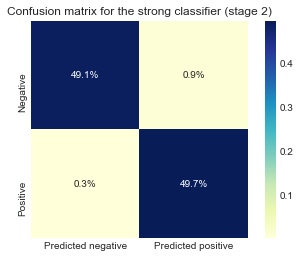

In [ ]:
ys_strong = np.array([strong_classifier(x, weak_classifiers_2) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for the strong classifier (stage 2)');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Let's test it on Einstein:

In [ ]:
strong_classifier(to_integral(normalize(EINSTEIN)), weak_classifiers_2)

1

In [ ]:
weak_classifiers_3, w_history_3 = build_weak_classifiers('3rd', 25, xis, ys, features)  # , w_history_2[-1])

Building weak classifier 1/25 ...
t=1/25 0.16s (0.16s in this stage) 1/24976 0.00% evaluated. Classification error improved to 0.38650 using Feature2h(x=0, y=0, width=2, height=1) ...
t=1/25 0.32s (0.32s in this stage) 6/24976 0.02% evaluated. Classification error improved to 0.33493 using Feature2h(x=0, y=5, width=2, height=1) ...
t=1/25 0.63s (0.63s in this stage) 16/24976 0.06% evaluated. Classification error improved to 0.29121 using Feature2h(x=1, y=0, width=2, height=1) ...
t=1/25 0.79s (0.79s in this stage) 17/24976 0.06% evaluated. Classification error improved to 0.24543 using Feature2h(x=1, y=1, width=2, height=1) ...
t=1/25 0.94s (0.94s in this stage) 22/24976 0.08% evaluated. Classification error improved to 0.20250 using Feature2h(x=1, y=6, width=2, height=1) ...
t=1/25 8.17s (8.16s in this stage) 231/24976 0.92% evaluated. Classification error improved to 0.20007 using Feature2h(x=1, y=6, width=2, height=2) ...
t=1/25 18.49s (18.49s in this stage) 514/24976 2.05% evaluate

In [ ]:
weak_classifiers_3

[WeakClassifier(threshold=1.7015151977539062, polarity=-1, alpha=2.542550127523093, classifier=Feature2v(x=9, y=4, width=2, height=4)),
 WeakClassifier(threshold=6.038299560546875, polarity=-1, alpha=2.2009272323575204, classifier=Feature2h(x=10, y=0, width=4, height=7)),
 WeakClassifier(threshold=-0.18675613403320312, polarity=1, alpha=1.7204232871439578, classifier=Feature2v(x=8, y=13, width=1, height=2)),
 WeakClassifier(threshold=0.8092565536499023, polarity=-1, alpha=1.984026722870052, classifier=Feature2h(x=7, y=3, width=4, height=2)),
 WeakClassifier(threshold=-1.3431625366210938, polarity=1, alpha=1.8695988650569482, classifier=Feature3h(x=7, y=5, width=3, height=5)),
 WeakClassifier(threshold=-1.9090153574943542, polarity=1, alpha=1.970750774732717, classifier=Feature2h(x=1, y=1, width=4, height=2)),
 WeakClassifier(threshold=0.24900221824645996, polarity=-1, alpha=1.8931765177348336, classifier=Feature2v(x=4, y=5, width=1, height=2)),
 WeakClassifier(threshold=-0.726253986358

Precision 0.99, recall 1.00, false positive rate 0.01, false negative rate 0.00.


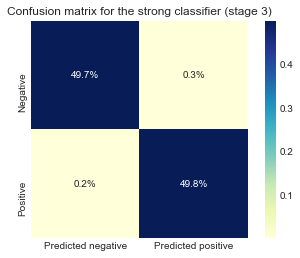

In [ ]:
ys_strong = np.array([strong_classifier(x, weak_classifiers_3) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for the strong classifier (stage 3)');

print(f'Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Let's test it on Einstein:

In [6]:
strong_classifier(to_integral(normalize(EINSTEIN)), weak_classifiers_3)

1


## Test the classifiers

In [ ]:
rows, cols = integral.shape[0:2]
HALF_WINDOW = WINDOW_SIZE // 2

face_positions_1 = []
face_positions_2 = []
face_positions_3 = []

normalized_integral = to_integral(normalize(grayscale))

for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW):
    for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW):
        window = normalized_integral[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
                
        # First cascade stage
        probably_face = strong_classifier(window, weak_classifiers)
        if probably_face < .5:
            continue
        face_positions_1.append((row, col))
            
        # Second cascade stage
        probably_face = strong_classifier(window, weak_classifiers_2)
        if probably_face < .5:
            continue
        face_positions_2.append((row, col))
            
        # Third cascade stage 
        probably_face = strong_classifier(window, weak_classifiers_3)
        if probably_face < .5:
            continue
        face_positions_3.append((row, col))
    
print(f'Found {len(face_positions_1)} candidates at stage 1, {len(face_positions_2)} at stage 2 and {len(face_positions_3)} at stage 3.')

Found 12689 candidates at stage 1, 975 at stage 2 and 141 at stage 3.


In [ ]:
def render_candidates(image: Image.Image, candidates: List[Tuple[int, int]]) -> Image.Image:
    canvas = to_float_array(image.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return to_image(canvas)

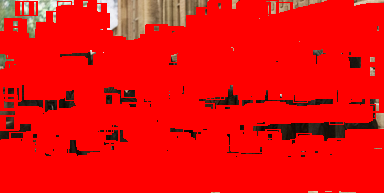

In [ ]:
render_candidates(thumbnail_image, face_positions_1)

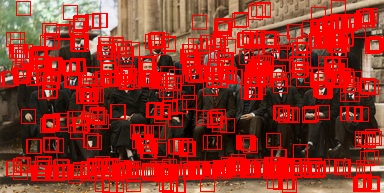

In [ ]:
render_candidates(thumbnail_image, face_positions_2)

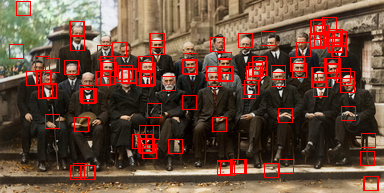

In [ ]:
render_candidates(thumbnail_image, face_positions_3)